In [1]:
# Import the required packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Read the data
claims = pd.read_csv("C:/Users/Arpita/Desktop/AnalytixLabs_new/Case Studies/Python Case Studies/Python Foundation Case Study 3 - Insurance Claims Case Study/claims.csv")
demo = pd.read_csv("C:/Users/Arpita/Desktop/AnalytixLabs_new/Case Studies/Python Case Studies/Python Foundation Case Study 3 - Insurance Claims Case Study/cust_demographics.csv")

In [3]:
claims.columns

Index(['claim_id', 'customer_id', 'incident_cause', 'claim_date', 'claim_area',
       'police_report', 'claim_type', 'claim_amount', 'total_policy_claims',
       'fraudulent'],
      dtype='object')

In [4]:
demo.columns

Index(['CUST_ID', 'gender', 'DateOfBirth', 'State', 'Contact', 'Segment'], dtype='object')

In [5]:
# Join the datasets
claims360 = pd.merge(left = demo, right = claims, how = "inner", left_on = "CUST_ID", right_on = "customer_id", indicator = False)

In [6]:
# Data Info including columns and their datatypes 
claims360.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CUST_ID              1085 non-null   int64  
 1   gender               1085 non-null   object 
 2   DateOfBirth          1085 non-null   object 
 3   State                1085 non-null   object 
 4   Contact              1085 non-null   object 
 5   Segment              1085 non-null   object 
 6   claim_id             1085 non-null   int64  
 7   customer_id          1085 non-null   int64  
 8   incident_cause       1085 non-null   object 
 9   claim_date           1085 non-null   object 
 10  claim_area           1085 non-null   object 
 11  police_report        1085 non-null   object 
 12  claim_type           1085 non-null   object 
 13  claim_amount         1020 non-null   object 
 14  total_policy_claims  1075 non-null   float64
 15  fraudulent           1085 non-null   o

In [7]:
# Data size
claims360.size

17360

In [8]:
# Coverting DOB to datetime column type 
dob = pd.to_datetime(claims360.DateOfBirth, format = "%d-%b-%y")
dob[(dob.dt.year > 2000 )] = dob - pd.DateOffset(years = 100)
claims360.DateOfBirth = dob

In [9]:
# Conversion function for claim date variable to convert in proper datetime format
def date_formats( x ):
    if x.find( '/' ) == -1:
        dte = pd.to_datetime( x, format = '%d-%m-%Y' )
    else:
        dte = pd.to_datetime( x, format = '%m/%d/%Y' )
        
    return dte

In [10]:
claims360.claim_date = claims360.claim_date.apply( date_formats )

In [11]:
# Claim amount to be converted into float type from object type variable
claims360.claim_amount = claims360.claim_amount.str.replace("$", "").astype(float)

C:\Users\Arpita\AppData\Local\Temp\ipykernel_2724\4153199905.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  claims360.claim_amount = claims360.claim_amount.str.replace("$", "").astype(float)


In [12]:
# Alert flag for unreported injury claims
claims360['Alert_Flag'] = np.where((claims360['claim_type'] == "Injury only") & (claims360['police_report'] == "Unknown"),1,0)

In [13]:
# Keeping only latest entries by custid 
claims360 = claims360.sort_values('claim_date', ascending = True).drop_duplicates(['CUST_ID'], keep = "last")

In [14]:
# shape of the data
claims360.shape

(1078, 17)

In [15]:
# Check of missings in each column 
for var in claims360.columns:
    print( var , " | " + str(claims360[var].dtype),  "|  Missings: " + str(claims360[var].isnull().sum()))   

CUST_ID  | int64 |  Missings: 0
gender  | object |  Missings: 0
DateOfBirth  | datetime64[ns] |  Missings: 0
State  | object |  Missings: 0
Contact  | object |  Missings: 0
Segment  | object |  Missings: 0
claim_id  | int64 |  Missings: 0
customer_id  | int64 |  Missings: 0
incident_cause  | object |  Missings: 0
claim_date  | datetime64[ns] |  Missings: 0
claim_area  | object |  Missings: 0
police_report  | object |  Missings: 0
claim_type  | object |  Missings: 0
claim_amount  | float64 |  Missings: 65
total_policy_claims  | float64 |  Missings: 10
fraudulent  | object |  Missings: 0
Alert_Flag  | int32 |  Missings: 0


In [17]:
# Imputting missings with appropriate values
claims360.claim_amount = claims360.claim_amount.fillna(claims360.claim_amount.mean())
claims360.total_policy_claims = claims360.total_policy_claims.fillna(claims360.total_policy_claims.mode()[0])

In [18]:
# Calculating age of customers
Age = claims360.claim_date.min().year - claims360.DateOfBirth.dt.year

In [19]:
# Creating age groups
claims360['AgeGrp'] = pd.cut(Age , [17,30,60], labels = ['Youth','Adult'])

In [20]:
# Average amount claimed by segments
claims360.groupby('Segment').claim_amount.mean().round(2)

Segment
Gold        12846.40
Platinum    12371.65
Silver      12267.86
Name: claim_amount, dtype: float64

In [21]:
# Amount claimed by incident cause 20 days prior to 1st Oct 2018
claims360[claims360.claim_date < "2018-09-11"].groupby('incident_cause').claim_amount.sum().astype(int)

incident_cause
Crime                  655988
Driver error          3410190
Natural causes        1282457
Other causes          3672218
Other driver error    3308641
Name: claim_amount, dtype: int32

In [22]:
# Adults with driver related issues living in TX or DE or AK
claims360[(claims360['AgeGrp'] == "Adult") & (claims360.State.isin(['TX','DE','AK'])) & \
          (claims360.incident_cause.isin(['Driver error','Other driver error']))].shape[0]

23

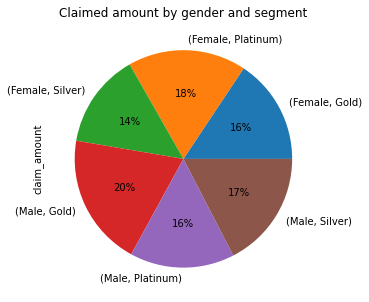

In [23]:
# Claimed amount by gender and segment
claims360.groupby(['gender','Segment']).claim_amount.sum().astype(int).plot(kind= "pie", figsize= (5,5), autopct = '%1.0f%%')
plt.title("Claimed amount by gender and segment")
plt.show()

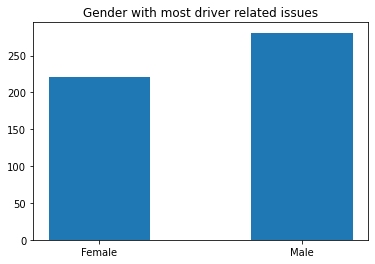

In [55]:
# Gender with most driver related issues
summ0 = claims360[claims360.incident_cause.isin(['Driver error','Other driver error'])].groupby('gender').CUST_ID.count()
plt.figure( figsize = (6, 4))
plt.bar( x = summ0.index, height = summ0.values , width = 0.5)
plt.title("Gender with most driver related issues")
plt.show()

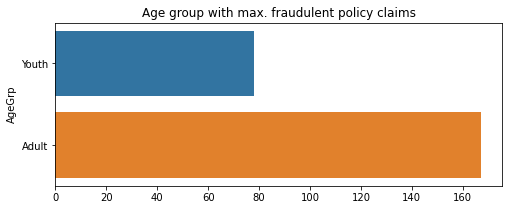

In [48]:
# Age group with max. fraudulent policy claims
summ = claims360[claims360['fraudulent'] == "Yes"].groupby("AgeGrp").CUST_ID.count()
plt.figure( figsize = (8, 3))
plt.title("Age group with max. fraudulent policy claims")
sns.barplot( y = summ.index, x = summ.values)
plt.show()

In [26]:
# Creating month variable 
claims360['Month'] = pd.to_datetime(claims360.claim_date, format = "%Y-%m-%d").dt.strftime("%b")

In [27]:
# Sort the month values in chronological order
sort_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [28]:
claims360['Month'] = pd.CategoricalIndex(claims360['Month'], categories = sort_order, ordered = True)

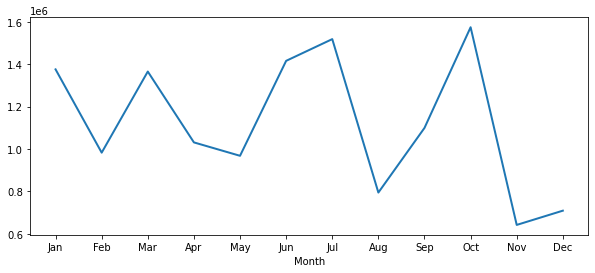

In [29]:
# Total amount claimed month wise
plt.xticks( range(0,len(claims360.Month)), claims360.Month)
claims360.groupby('Month').claim_amount.sum().plot(figsize = (10,4), linewidth = 2)
plt.show()

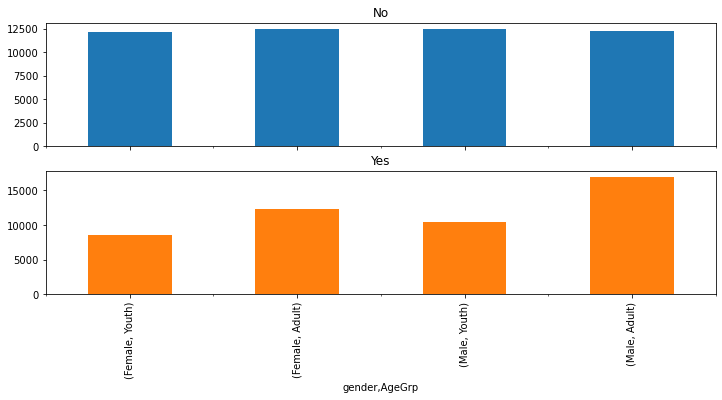

In [30]:
# claimed amount by gender and agegrp for fraudulent claims and non-fraudulent claims
claims360.groupby(['gender','AgeGrp','fraudulent']).claim_amount.mean().unstack().plot(kind = "bar", subplots = True, figsize= (12,5), legend = False)
plt.show()

### Test of amount claimed by females and males

In [31]:
claims360.gender.value_counts()

Male      551
Female    527
Name: gender, dtype: int64

In [56]:
# actual means of claimed amount by males and females
male_amt = claims360.loc[ claims360.gender == "Male", 'claim_amount' ]
female_amt = claims360.loc[ claims360.gender == "Female", 'claim_amount' ]

print( 'mean of male claimed amt: ', male_amt.mean(), '| mean of female claimed amt: ', female_amt.mean() )

mean of male claimed amt:  12884.845110657638 | mean of female claimed amt:  12101.160474551885


In [33]:
# Using independent sample t-test to find if claim amount varies with gender
stats.ttest_ind( male_amt, female_amt )

Ttest_indResult(statistic=0.962509344663214, pvalue=0.33601006135365363)

### Relationship between age group and segment

In [34]:
# Cross table of AgeGrp and Segment 
obs_freq = pd.crosstab( claims360.AgeGrp, claims360.Segment )
obs_freq

Segment,Gold,Platinum,Silver
AgeGrp,,,
Youth,120,129,114
Adult,251,232,232


In [35]:
# Chi2 test to find relation between two categorical variables
stats.chi2_contingency( obs_freq )

(1.061001766401299,
 0.5883102211606773,
 2,
 array([[124.92857143, 121.56122449, 116.51020408],
        [246.07142857, 239.43877551, 229.48979592]]))

### Is there any rise in claim amount compared to 2016-2017 fiscal average of $10000

In [36]:
# Mean amount in year 2016-2017 = 10000
# Mean of amount claimed in current year (2018)
claims360.loc[claims360.claim_date.dt.year == 2018, "claim_amount"].mean()

12743.43753167584

In [37]:
# Using 1-sample t-test
stats.ttest_1samp( claims360.loc[claims360.claim_date.dt.year == 2018, "claim_amount"], 10000.0 )

Ttest_1sampResult(statistic=4.477343563243788, pvalue=9.435844221983294e-06)

### Difference between age groups and insurance claims

In [38]:
claims360.AgeGrp.value_counts()

Adult    715
Youth    363
Name: AgeGrp, dtype: int64

In [39]:
# data processing for the test
s1 = claims360.loc[ claims360.AgeGrp == "Adult", 'claim_amount' ]
s2 = claims360.loc[ claims360.AgeGrp == "Youth", 'claim_amount' ]
    
print( 'mean Adult:', s1.mean(), '| mean Youth:', s2.mean())

mean Adult: 12889.626277966854 | mean Youth: 11737.681645495606


In [40]:
# Using independent sample t-test
stats.ttest_ind( s1, s2 )

Ttest_indResult(statistic=1.338118654716883, pvalue=0.18114046655055735)

### Relationship between total no. of policy claims and claimed amount

In [42]:
claims360.total_policy_claims = claims360.total_policy_claims.astype(int)

In [43]:
stats.pearsonr( claims360.claim_amount,claims360.total_policy_claims )

(-0.022401566777628945, 0.4624932766041746)